Import libraries and packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random
import copy
import math
import time

# Part 1 - Formalism

State is represented by the coordinates and direction of Bee-bot. The map is not included in the state, and only serves as a reference to check Bee-bot's position on the map and whether it has reached the goal.

<u>Bee-bot</u> (the state)
* Represented by a 1D-array: [bee_row, bee_col, bee_direction]
* bee_direction index corresponds to the following: 0 = North, 1 = East, 2 = South, 3 = West
* Initial state is randomly initialised, whereby map[bee_row][bee_col] == 0
* Goal state reached when map[bee_row][bee_col] == 2

<u>Map</u>
* Represented by a 2D-array (m by n dimensions)
* Empty cell = 0
* Obstacles = 1
* Goal cell = 2

<u>Conditions</u>
* 0 <= bee_row <= m
* 0 <= bee_col <= n
* 0 <= bee_direction <= 3
* map[bee_row][bee_col] != 1 (Bee-bot cannot be on an obstacle cell labelled 1)

<u>Print State function</u>

In [6]:
def printState(map, state):
    # Standardise the cell size of the figure plotted, for visualisation purposes
    rows = len(map)
    cols = len(map[0])
    dpi = 50
    cell_size = 0.5
    width = cols * cell_size
    height = rows * cell_size
    fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)

    # Empty cells are white, obstacles are black, goal cell is green
    cmap = mcolors.ListedColormap(['white', 'black', 'green'])
    ax.imshow(map, cmap=cmap)

    # Plot Beebot's position and direction as a red triangle on the map
    y, x, direction = state
    direction_markers = ['^', '>', 'v', '<']
    marker = direction_markers[direction]
    plt.plot(x, y, marker, color='red', markersize=cell_size*dpi*0.5)

    plt.rcParams.update({'figure.max_open_warning': 0})

    plt.show

Example initial state and final state:
* map = [[0,0,2,0,0],[0,1,1,1,0],[0,0,1,0,0],[1,0,0,0,1],[0,0,1,1,1],[0,1,1,1,1],[0,0,1,1,1],[1,0,1,1,1]]
* initialState = [7,1,0], whereby map[7][1] == 0
* finalState = [0,2,1], whereby map[0][2] == 2

Initial State:


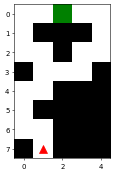

In [8]:
testmap = [[0,0,2,0,0],[0,1,1,1,0],[0,0,1,0,0],[1,0,0,0,1],[0,0,1,1,1],[0,1,1,1,1],[0,0,1,1,1],[1,0,1,1,1]]
testInitialState = [7,1,0]
testFinalState = [0,2,1]

print('Initial State:')
printState(testmap, testInitialState)

Final State:


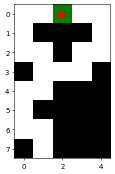

In [9]:
print('Final State:')
printState(testmap, testFinalState)

# Part 2 - List of actions

<u>List of Actions function</u>
* This function sequences the possible actions based on the current direction Bee-bot is facing.
* Bee-bot has 4 actions - 1) move forward, 2) move backwards, 3) turn 90 degrees left, and 4) turn 90 degrees right.
* The directions from Bee-bot's perspective may not necessarily align with the cardinal directions of the map. For example, if Bee-bot is currently facing East and it wanted to turn and move to its right, it would be moving further down (South) of the map rather than actually moving to the right (East) of the map.
* For the purposes of DFS, the sequence of actions are: 1) step backward, 2) turn right, 3) turn left, 4) step forward. This is to prioritise the step-forward action since DFS is Last-In-First-Out.

In [12]:
def listOfActions(state):
    # Define the changes in y and x for each of the four cardinal directions
    direction = state[2]
    step_direction = [[-1, 0, 0], [0, 1, 0], [1, 0, 0], [0, -1, 0]] # North, East, South, West

    forward = step_direction[direction] # Index the step-forward action based on the direction Bee-bot is facing
    backward = [x * -1 for x in forward] # Reverse the coordinates of the step-forward action to get step-backward action

    availableActions = [backward, [0, 0, 1], [0, 0, -1], forward] # step backward, turn right, turn left, step forward

    return availableActions

<u>Check Valid State function</u>
* Checks if next action is valid

In [14]:
def checkValidState(map, next):
    y = next[0] # Row index of next Bee-bot state
    x = next[1] # Col index of next Bee-bot state

    map_height = len(map)-1
    map_width = len(map[0])-1

    # Check if Bee-bot's coordinates exceed the top/bottom borders of the map
    if y < 0 or y > map_height:
        return False
    # Check if Bee-bot's coordinates exceed the left/right borders of the map
    if x < 0 or x > map_width:
        return False
    # Check if Bee-bot is on an obstacle cell
    if map[y][x] == 1:
        return False
    return True

# Part 3 - Map Generator

In [16]:
def mapGenerator(width, height):
    # Generate map
    map  = []
    for row in range(height):
        map.append(random.choices([0, 1], weights=[0.8, 0.2], k=width))

    # Randomly set goal cell
    while True:
        goal_row = random.randint(0, height-1)
        goal_col = random.randint(0, width-1)
        if map[goal_row][goal_col] == 0:
            map[goal_row][goal_col] = 2
            break

    # Randomly set Bee-bot initial position
    while True:
        bee_row = random.randint(0, height-1)
        bee_col = random.randint(0, width-1)
        bee_dir = random.randint(0, 3)
        if map[bee_row][bee_col] == 0:
            state = [bee_row, bee_col, bee_dir]
            break

    return map, state

Set dimensions and preview map

Please enter map width:  11
Please enter map height:  11


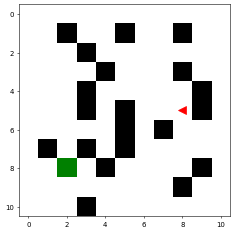

In [18]:
width = int(input("Please enter map width: "))
height = int(input("Please enter map height: "))

map, initialState = mapGenerator(width, height)
printState(map, initialState)

# Part 4 - Depth-First-Search implementation

<u>Print solution function</u>

In [21]:
def getFinalSolution(map, initState, goalState, trackingDict):
    path = []
    state = goalState
    while state != initState:
        # append the state to path
        path.append(state)

        # convert the state to a string so we can search for it in the dictionary
        listToStr = ' '.join([str(elem) for elem in state])

        # get the value from the dictionary and use it to call the function again
        state = trackingDict[listToStr]

    path.append(initState)
    path.reverse()
    return path

def printFinalSolution(map, initState, goalState, trackingDict):
    path = getFinalSolution(map, initState, goalState, trackingDict)

    # Display the path
    for step in path:
        printState(map, step)
        print()

    print("***Path found took {} actions***".format(len(path)-1))

<u>Depth-First-Search algorithm function</u>

In [23]:
def DFS(map, initialState):
    visitedStates = []
    trackingDictionary = {} # Saving all visited states and their previous state to track the solution once found
    agenda = []
    agenda.append(initialState)
    finalStateReached = False

    while (agenda != [ ]):
        current = agenda.pop()
        visitedStates.append(current)
        if map[current[0]][current[1]] == 2: # Check if the goal is met
            finalStateReached = True
            break
        possibleActions = listOfActions(current)
        for action in possibleActions:
            nextState = copy.deepcopy(current)
            nextState[0] += action[0]
            nextState[1] += action[1]
            nextState[2] = (nextState[2] + action[2]) % 4
            if checkValidState(map, nextState): # Check if the next state is valid
                if ((nextState not in visitedStates) and (nextState not in agenda)): # Check if we have already seen this state before
                    listToStr = ' '.join([str(elem) for elem in nextState])
                    trackingDictionary[listToStr] = current
                    agenda.append(nextState)

    return finalStateReached, current, visitedStates, trackingDictionary

The final state is reached
Time elapsed: 0.0020 seconds

Final Solution:





















































***Path found took 52 actions***


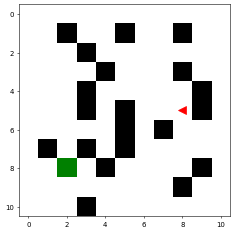

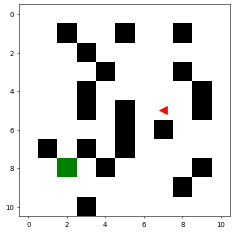

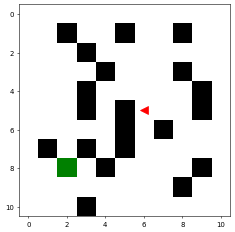

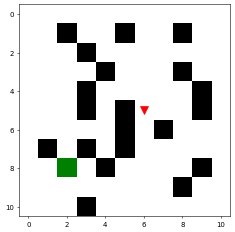

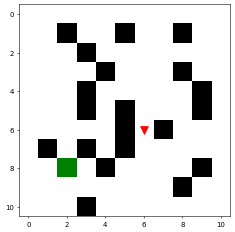

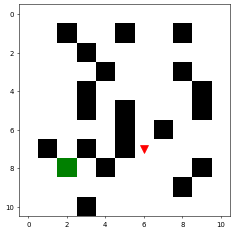

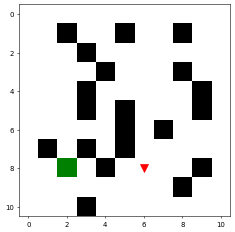

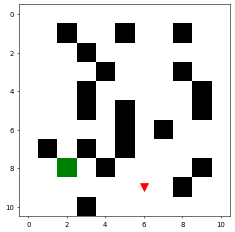

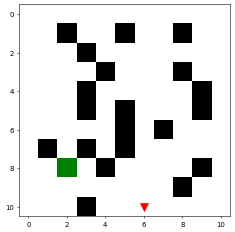

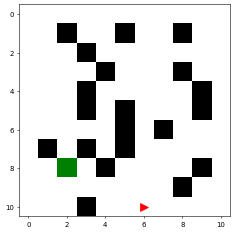

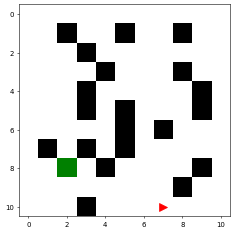

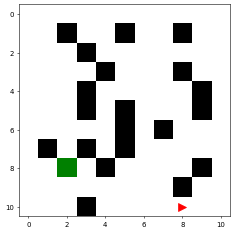

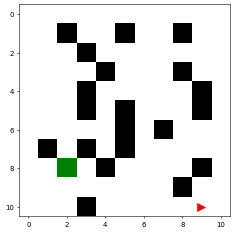

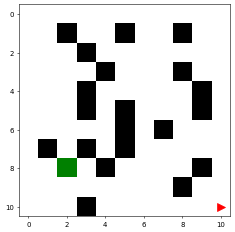

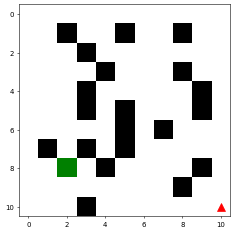

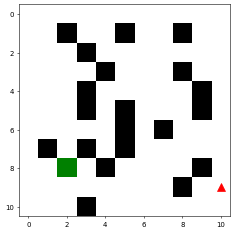

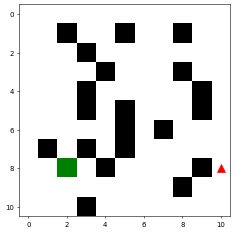

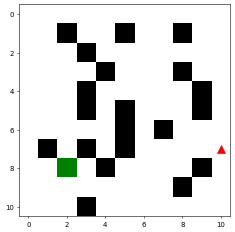

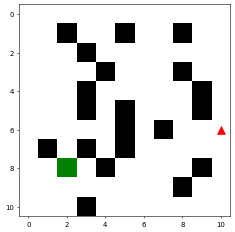

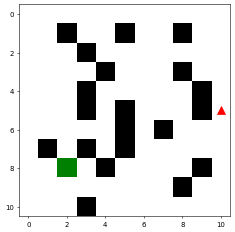

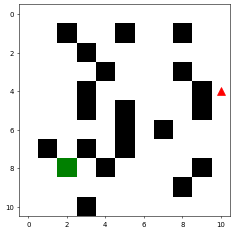

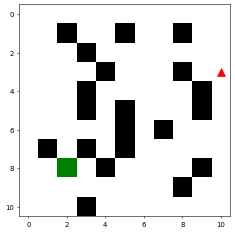

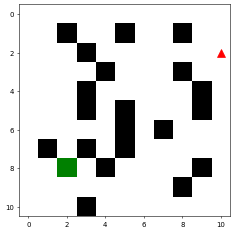

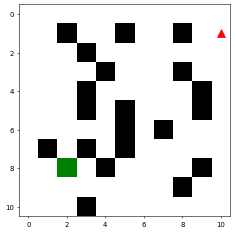

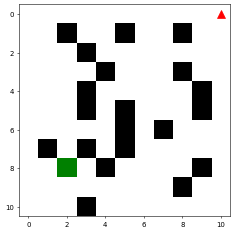

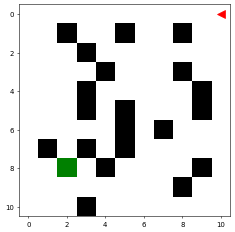

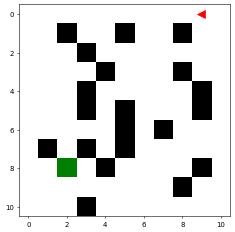

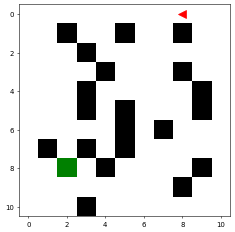

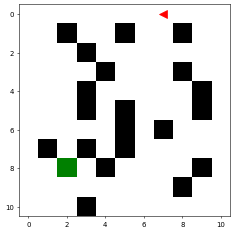

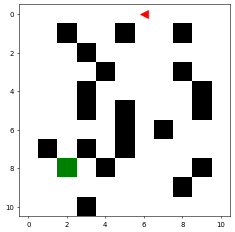

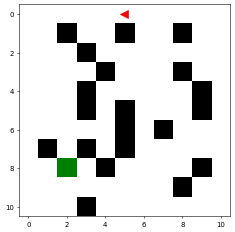

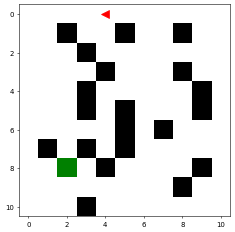

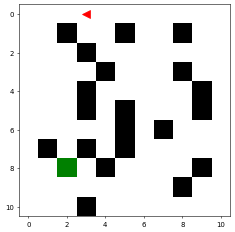

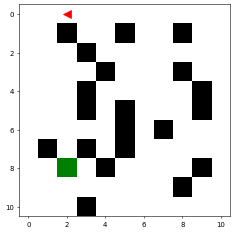

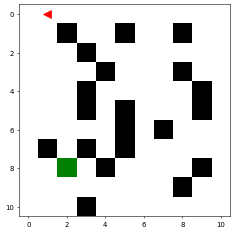

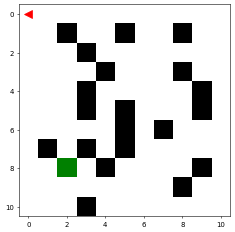

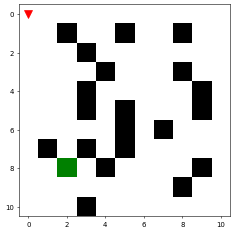

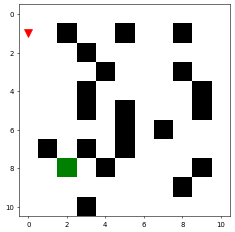

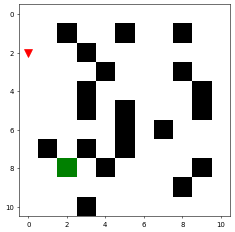

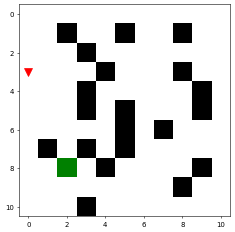

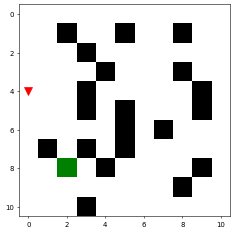

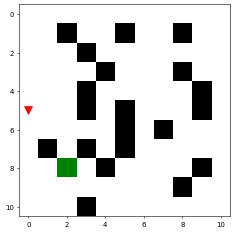

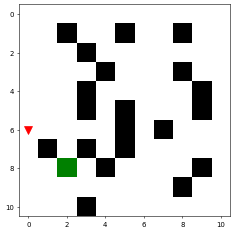

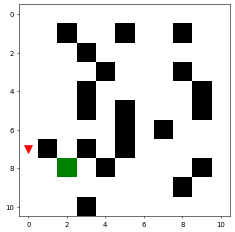

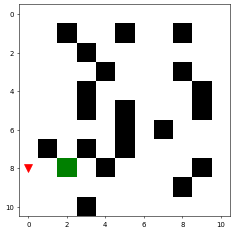

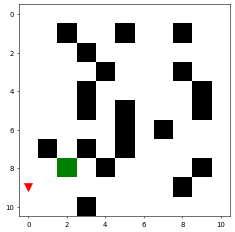

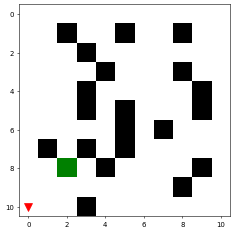

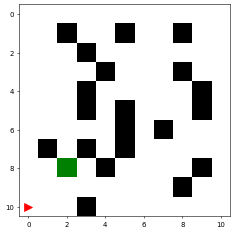

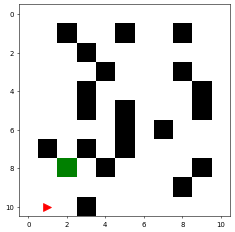

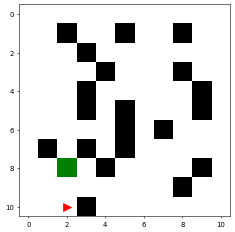

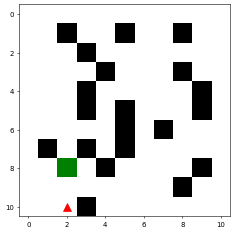

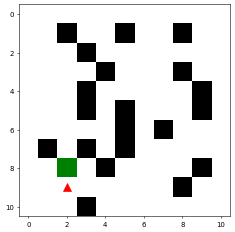

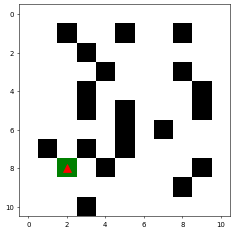

In [24]:
start = time.time() # Start time

# Run DFS algorithm
finalStateReached_DFS, current_DFS, visitedStates_DFS, trackingDictionary_DFS = DFS(map, initialState)

end = time.time() # End time

duration = end - start # Calculate time elapsed

if (finalStateReached_DFS):
    print("The final state is reached")
    print("Time elapsed: {:.4f} seconds".format(duration))
    print('\nFinal Solution:')
    printFinalSolution(map, initialState, current_DFS, trackingDictionary_DFS)
else:
    print("The final state was not reached")

# Part 5 - A* search implementation

<u>Evaluation function</u>
* Using Manhattan distance as it is the minimum number of cells Bee-bot has to move to reach the goal
* Hence, heuristic h is admissable since h(s) ≤ h\*(s) in any scenario, whereby h* is the true cost to the goal



In [27]:
def distanceEvaluation(map, state):
    bee_row = state[0]
    bee_col = state[1]
    for i in range(len(map)):
        for j in range(len(map[i])):
            if map[i][j] == 2:
                return abs(i - bee_row) + abs(j - bee_col)

In [28]:
print(distanceEvaluation(map, initialState))

9


<u>Check if State is in Agenda function</u>
* This function searches for a state currently in the agenda, and returns its index and associated cost if found.
* Each agenda item contains [state, cost, eval].
* 2 same states may have different costs, depending on the path taken to that state.
* As such, if a new state about to be added to the agenda has a lower cost than a similar state already in the agenda, we shall update the old state's cost to the new one, without having to append a new agenda item.




In [30]:
def checkIfStateIsInAgenda(ag, st):
    for index in range(len(ag)):
        stAg = ag[index]
        # Compare the new state st with the first value of stAg
        if (st == stAg[0]):
            return ([index, stAg[1]]) # Return index and cost if similar state is in agenda
    # Return False if similar state is not in agenda
    return False

A* Search algorithm function

In [32]:
def AStar(map, initialState):
    visitedStates = []
    trackingDictionary = {} # Saving all visited states and their previous state to track the solution once found
    agenda = []
    agenda.append([initialState, 0, distanceEvaluation(map, initialState)]) # Added states to the agenda will have the form [state, cost, eval]
    finalStateReached = False
    finalStateCost = 0

    while (agenda != []):
        bestStateIndex = -1
        bestStateValue = math.inf
        for i in range(len(agenda)):
            if (agenda[i][1] + agenda[i][2] < bestStateValue):
                bestStateValue = agenda[i][1] + agenda[i][2]
                bestStateIndex = i
        currentPop = agenda.pop(bestStateIndex)
        current = currentPop[0]
        currentCost = currentPop[1]
        visitedStates.append(current)
        if map[current[0]][current[1]] == 2: # check if the goal is met
            finalStateReached = True
            finalStateCost = currentCost
            break
        possibleActions = listOfActions(current)
        for action in possibleActions:
            nextState = copy.deepcopy(current)
            nextState[0] += action[0]
            nextState[1] += action[1]
            nextState[2] = (nextState[2] + action[2]) % 4
            if checkValidState(map, nextState): # Check if the next state is valid
                if nextState not in visitedStates: # Check if we have already seen this state before
                    checkIfInAgenda = checkIfStateIsInAgenda(agenda, current)
                    if checkIfInAgenda != False:
                        oldCost = checkIfInAgenda[1] # the cost is the second value, the first is the index
                        newCost = currentCost + 1 # New cost of applying the action
                        if (oldCost > newCost): # Already in the agenda but with a higher cost, replace it with the new one
                            index = checkIfInAgenda[0]
                            agenda[index][1] = newCost # 1st replace the cost in the agenda
                            listToStr = ''.join([str(elem) for elem in nextState]) # 2nd replace it in tracking dictionary and convert to string
                            trackingDictionary[listToStr]=current # Update its value in the dictionary
                    elif checkIfInAgenda == False: # If not in the agenda, add it
                        listToStr = ' '.join([str(elem) for elem in nextState])
                        trackingDictionary[listToStr]=current
                        agenda.append([nextState, currentCost+1, distanceEvaluation(map, nextState)])

    return finalStateReached, finalStateCost, current, visitedStates, trackingDictionary

The final state is reached at cost 14
Time elapsed: 0.0110 seconds

Final Solution:















***Path found took 14 actions***


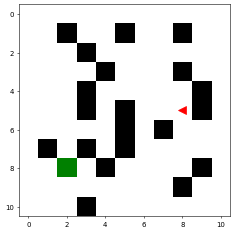

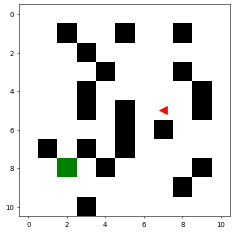

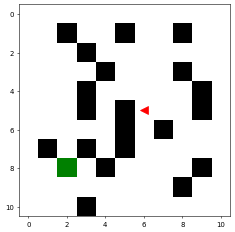

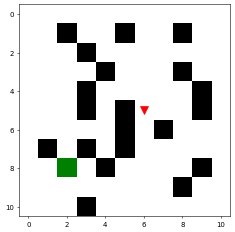

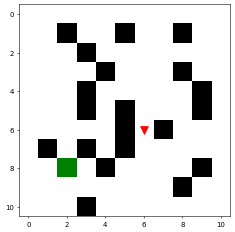

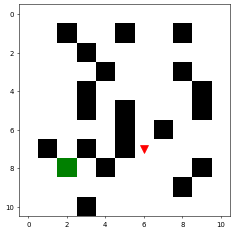

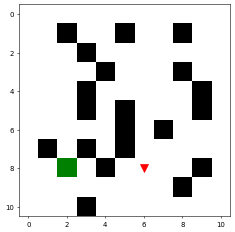

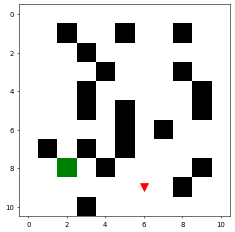

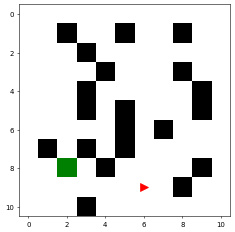

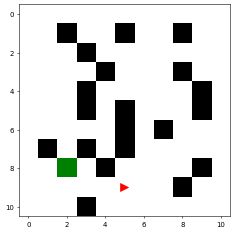

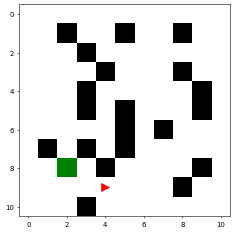

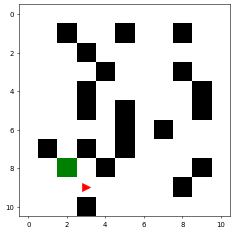

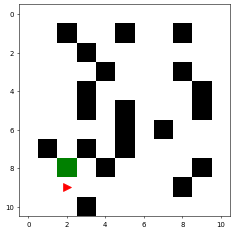

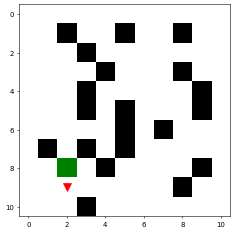

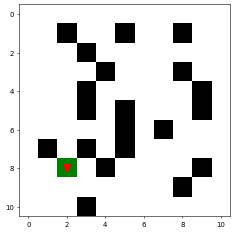

In [33]:
start = time.time() # Start time

# Run A* algorithm
finalStateReached_AStar, finalStateCost, current_AStar, visitedStates_AStar, trackingDictionary_AStar = AStar(map, initialState)

end = time.time() # End time

duration = end - start # Calculate time elapsed

if (finalStateReached_AStar):
    print("The final state is reached at cost {}".format(finalStateCost))
    print("Time elapsed: {:.4f} seconds".format(duration))
    print('\nFinal Solution:')
    printFinalSolution(map, initialState, current_AStar, trackingDictionary_AStar)
else:
    print("The final state was not reached")

# Part 6 - Compare DFS vs A*

To compare the speed and efficiency of DFS and A* algorithms, we will generate and save 5 different maps of increasing dimensions for analysis: 11x11, 21x21, 31x31, 41x41, 51x51. This will be repeated 20 times using different seeds and the average metrics for each map size will be tabulated.

For speed, we will compare in terms of search runtime (search speed) and number of actions in the path found (path speed). For efficiency, we will compare in terms of number of nodes visited in the search tree.

1. Search runtime (search speed)
2. Number of actions (path speed)
3. Number of nodes visited in search tree (efficiency)

In [36]:
dimensions = [11, 21, 31, 41, 51]
iterations = 20

# To collect the average metrics of each map size
timings = []
paths = []
nodes = []

for dim in range(len(dimensions)):
    # To collect 20 measurements of each metric for each map size using DFS
    timingsList_DFS = []
    pathsList_DFS = []
    nodesList_DFS = []

    # To collect 20 measurements of each metric for each map size using A*
    timingsList_AStar = []
    pathsList_AStar = []
    nodesList_AStar = []

    for i in range(iterations):
        # Generate map using different seeds
        random.seed(123+i)
        map_generated, initialState_generated = mapGenerator(dimensions[dim], dimensions[dim])

        print(f'Analysing {dimensions[dim]}x{dimensions[dim]} map ({i+1} of {iterations})')

        # DFS
        startTime = time.time()
        _, final_state, visited_states, trackingDict = DFS(map_generated, initialState_generated)
        endTime = time.time()
        duration = endTime - startTime

        timingsList_DFS.append(duration) # Record search runtime
        path = getFinalSolution(map_generated, initialState_generated, final_state, trackingDict)
        pathsList_DFS.append(len(path)) # Record number of actions in path found
        nodesList_DFS.append(len(visited_states)) # Record number of nodes visited

        # A*
        startTime = time.time()
        _, _, final_state, visited_states, trackingDict = AStar(map_generated, initialState_generated)
        endTime = time.time()
        duration = endTime - startTime

        timingsList_AStar.append(duration) # Record search runtime
        path = getFinalSolution(map_generated, initialState_generated, final_state, trackingDict)
        pathsList_AStar.append(len(path)) # Record number of actions in path found
        nodesList_AStar.append(len(visited_states)) # Record number of nodes visited

    # Collate the average timings, paths found, and visited nodes for a given map size
    timings.append([sum(timingsList_DFS)/len(timingsList_DFS), sum(timingsList_AStar)/len(timingsList_AStar)])
    paths.append([sum(pathsList_DFS)/len(pathsList_DFS), sum(pathsList_AStar)/len(pathsList_AStar)])
    nodes.append([sum(nodesList_DFS)/len(nodesList_DFS), sum(nodesList_AStar)/len(nodesList_AStar)])

compare_search_speed = pd.DataFrame(timings, index=['11 x 11', '21 x 21', '31 x 31', '41 x 41', '51 x 51'], columns=['DFS', 'A*'])
compare_path_speed = pd.DataFrame(paths, index=['11 x 11', '21 x 21', '31 x 31', '41 x 41', '51 x 51'], columns=['DFS', 'A*'])
compare_efficiency = pd.DataFrame(nodes, index=['11 x 11', '21 x 21', '31 x 31', '41 x 41', '51 x 51'], columns=['DFS', 'A*'])

Analysing 11x11 map (1 of 20)
Analysing 11x11 map (2 of 20)
Analysing 11x11 map (3 of 20)
Analysing 11x11 map (4 of 20)
Analysing 11x11 map (5 of 20)
Analysing 11x11 map (6 of 20)
Analysing 11x11 map (7 of 20)
Analysing 11x11 map (8 of 20)
Analysing 11x11 map (9 of 20)
Analysing 11x11 map (10 of 20)
Analysing 11x11 map (11 of 20)
Analysing 11x11 map (12 of 20)
Analysing 11x11 map (13 of 20)
Analysing 11x11 map (14 of 20)
Analysing 11x11 map (15 of 20)
Analysing 11x11 map (16 of 20)
Analysing 11x11 map (17 of 20)
Analysing 11x11 map (18 of 20)
Analysing 11x11 map (19 of 20)
Analysing 11x11 map (20 of 20)
Analysing 21x21 map (1 of 20)
Analysing 21x21 map (2 of 20)
Analysing 21x21 map (3 of 20)
Analysing 21x21 map (4 of 20)
Analysing 21x21 map (5 of 20)
Analysing 21x21 map (6 of 20)
Analysing 21x21 map (7 of 20)
Analysing 21x21 map (8 of 20)
Analysing 21x21 map (9 of 20)
Analysing 21x21 map (10 of 20)
Analysing 21x21 map (11 of 20)
Analysing 21x21 map (12 of 20)
Analysing 21x21 map (13 of

<u>Speed comparison</u> - search time taken in seconds

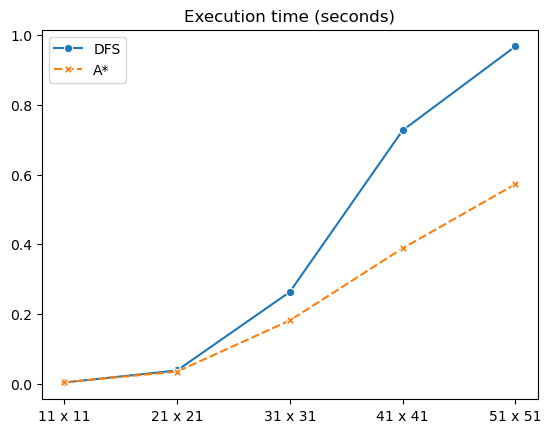

In [38]:
sns.lineplot(data=compare_search_speed, markers=True).set(title='Execution time (seconds)');

<u>Speed comparison</u> - number of actions in path found

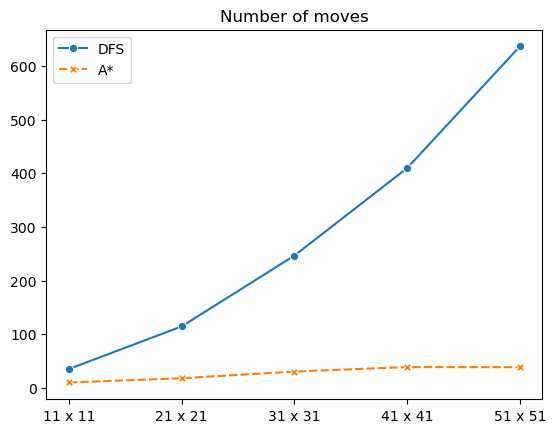

In [40]:
sns.lineplot(data=compare_path_speed, markers=True).set(title='Number of moves');

<u>Efficiency comparison</u> - number of nodes visited

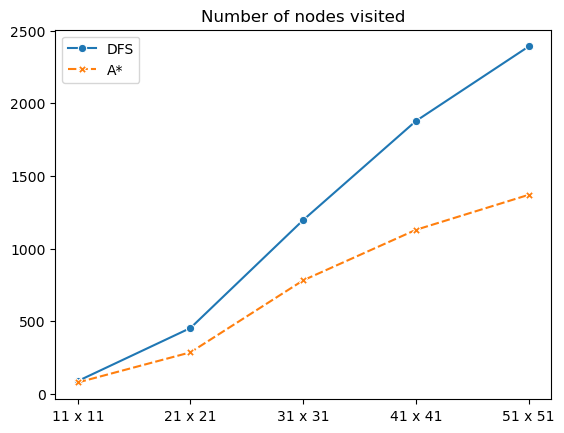

In [42]:
sns.lineplot(data=compare_efficiency, markers=True).set(title='Number of nodes visited');

<u>Conclusions</u>

Speed - search runtime
* When the map is small, DFS and A\* take approximately the same runtimes
* But DFS doesn't scale up well and takes a longer time for bigger maps like 51 x 51 as compared to A*.
* This is because A\* relies on the sum of the cost and heuristic (using Manhattan distance). This incentivises the Beebot to prioritise actions that take it physically closer to the goal, instead of wasting time fully exploring a suboptimal path to the maximum depth in the case of DFS.

Speed - number of actions in path found
* A\* consistently outperforms DFS, since A\* always finds the path with the fewest number of actions to the goal (optimal path).
* This is due to the nature of A\* having an admissible heuristic that never overestimates the cost of reaching the goal from a given state.

Efficiency - number of nodes visited in search tree
* When the map is small, DFS is more memory efficient than A* as it only needs to store a path from the root to the leaf node and backtracks when necessary. Whereas, A\* stores all of its nodes in memory.
* However, when the map is big, DFS is less memory efficient than A\*. This is because A\* uses the heuristic to avoid exploring unlikely paths.